# Lab9: Named entity recognition

In [218]:
import collections
import json
import matplotlib.pyplot as plt
import nltk
import os
import os.path
import requests
import time
import tqdm
import urllib.request

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/julia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
ACT_DIRECTORY = '../files'

In [4]:
BASE_URL = 'http://ws.clarin-pl.eu/nlprest2/base'

In [168]:
! mkdir -p ./ccl

In [169]:
RESULT_DIRECTORY = './ccl'

## Read the classification of [Named Entities](http://clarin-pl.eu/pliki/warsztaty/Wyklad3-inforex-liner2.pdf).
## Read the [API of NER](http://nlp.pwr.wroc.pl/redmine/projects/nlprest2/wiki) in [Clarin](http://ws.clarin-pl.eu/ner.shtml).
## Read the [documentation of CLL format](http://nlp.pwr.wroc.pl/redmine/projects/corpus2/wiki/CCL_format).

## Sort bills according to their size and take top 50 (largest) bills.

Wczytane zistały wszystkie pliki.

In [5]:
all_acts = {}

for root, _, files in os.walk(ACT_DIRECTORY):
    for file_name in files:
        path = os.path.join(root, file_name)
        with open(path, encoding='utf-8') as file:
            content = file.read()
            all_acts[path] = content

Z plików ustaw wybrane zostało 50 największych rozmiarowo.

In [6]:
top_acts = {
    pair[0]: pair[1] 
    for pair 
    in sorted(all_acts.items(), key=lambda pair: -len(pair[1]))[:50]
}

## Use the lemmatized and sentence split documents (from ex. 5) to identify the expressions that consist of consecutive words starting with a capital letter (you will have to look at the inflected form of the word to check its capitalization) that do not occupy the first position in a sentence. 
E.g. the sentence:
```
Wczoraj w Krakowie miało miejsce spotaknie prezydentów Polski i Stanów Zjednoczonych.
```
should yield the following entries: `Kraków`, `Polska`, `Stan Zjednoczony`.

### Lematyzacja

Przygotowana została funkcja pomocnicza potrzebna do lematyzacji tekstu. W instrukcji do piątego zadania nie znalazłam żadnej wzmianki na temat dzielenia tekstu na zdania, podobnie zresztą w swojej realizacji tego zadania. W związku z tym do realizacji tego zadania wykorzystana została biblioteka `nltk` i funkcje do tokenizacji zdań (`sent_tokenize`) oraz słów (`word_tokenize`). Po tokenizacji wykonana została lematyzacja z wykorzystaniem obrazku Dockerowego `djstrong/krnnt:1.0.0`. Jak wynika z [dokumentacji](https://github.com/kwrobel-nlp/krnnt), umożliwia on przekazywanie tekstu poddanego już wstępnej tokenizacji w formie JSON-a o następującym formacie:
```json
[
  [
    [["Lubię",true],["placki",true],[".",false]],
    [["Ala",true],["ma",true],["kota",true],[".",false]]
  ],
  [
    [["Raz",true],["dwa",true],["trzy",true],[".",false]]
  ]
]
```
Jako format wyjściowy wykorzystany został format `jsonl`, który również zachowuje podział na zdania (a format `json` z nieznanych mi powodów rzucał wyjątek).

In [7]:
# Just in case - I was having some issues with the 40th file
def retry_request(request):
    try:
        return request()
    except Exception as e:
        print('Error:', e)
        return retry_request(request)


def lemmatize(content):
    sentences = nltk.tokenize.sent_tokenize(content, language='polish')
    sentences = [nltk.tokenize.word_tokenize(sentence, language='polish') for sentence in sentences]
    request = [[[word, True] for word in sentence] for sentence in sentences]
    response = retry_request(
        lambda: requests.post('http://localhost:9003?output_format=jsonl', json=[request]).json()
    )
        
    lemmatized_content = []
    for raw_sentence, lemmatized_sentence in zip(sentences, response):
        resulting_sentence = []
        for raw_token, lemmatized_token in zip(raw_sentence, lemmatized_sentence):
            _, lemmatized_token, category = lemmatized_token
            category = category.split(':')[0]
            resulting_sentence += [(raw_token, lemmatized_token, category)]
            
        lemmatized_content += [resulting_sentence]
    
    return lemmatized_content

In [8]:
# sanity check
lemmatize('Podania w sprawach określonych w ustawie osoby zamieszkałe w\nPolsce składają organom, o których mowa w art. 8. Jeżeli\nwnioskodawca zamieszkuje za granicą, podanie składa się za\npośrednictwem konsula Rzeczypospolitej Polskiej.')

[[('Podania', 'podanie', 'subst'),
  ('w', 'w', 'prep'),
  ('sprawach', 'sprawa', 'subst'),
  ('określonych', 'określić', 'ppas'),
  ('w', 'w', 'prep'),
  ('ustawie', 'ustawa', 'subst'),
  ('osoby', 'osoba', 'subst'),
  ('zamieszkałe', 'zamieszkały', 'adj'),
  ('w', 'w', 'prep'),
  ('Polsce', 'Polska', 'subst'),
  ('składają', 'składać', 'fin'),
  ('organom', 'organ', 'subst'),
  (',', ',', 'interp'),
  ('o', 'o', 'prep'),
  ('których', 'który', 'adj'),
  ('mowa', 'mowa', 'subst'),
  ('w', 'w', 'prep'),
  ('art.', 'artykuł', 'brev'),
  ('8', '8', 'adj'),
  ('.', '.', 'interp')],
 [('Jeżeli', 'jeżeli', 'comp'),
  ('wnioskodawca', 'wnioskodawca', 'subst'),
  ('zamieszkuje', 'zamieszkiwać', 'fin'),
  ('za', 'za', 'prep'),
  ('granicą', 'granica', 'subst'),
  (',', ',', 'interp'),
  ('podanie', 'podanie', 'subst'),
  ('składa', 'składać', 'fin'),
  ('się', 'się', 'qub'),
  ('za', 'za', 'prep'),
  ('pośrednictwem', 'pośrednictwo', 'subst'),
  ('konsula', 'konsul', 'subst'),
  ('Rzeczypospol

Wykonana została lematyzacja wybranych 50 aktów prawnych.

In [9]:
lemmatized_acts = {}

with tqdm.tqdm(total=len(top_acts), position=0, leave=True) as pbar:
    for path, content in list(top_acts.items()):
        lemmatized_acts[path] = lemmatize(content)
        pbar.update()

100%|██████████| 50/50 [34:13<00:00, 41.07s/it] 


In [51]:
list(lemmatized_acts.values())[0][:5]

[[('Dz.U', 'dziennik ustaw', 'brev'), ('.', '.', 'interp')],
 [('z', 'z', 'prep'),
  ('1998', '1998', 'adj'),
  ('r.', 'rocznik', 'brev'),
  ('Nr', 'numer', 'brev'),
  ('106', '106', 'num'),
  (',', ',', 'interp'),
  ('poz.', 'poz.', 'subst'),
  ('668', '668', 'num'),
  ('USTAWA', 'ustawa', 'subst'),
  ('z', 'z', 'prep'),
  ('dnia', 'dzień', 'subst'),
  ('24', '24', 'adj'),
  ('lipca', 'lipiec', 'subst'),
  ('1998', '1998', 'adj'),
  ('r.', 'r.', 'subst'),
  ('o', 'o', 'prep'),
  ('zmianie', 'zmiana', 'subst'),
  ('niektórych', 'niektóry', 'adj'),
  ('ustaw', 'ustawa', 'subst'),
  ('określających', 'określać', 'pact'),
  ('kompetencje', 'kompetencja', 'subst'),
  ('organów', 'organ', 'subst'),
  ('administracji', 'administracja', 'subst'),
  ('publicznej', 'publiczny', 'adj'),
  ('-', '-', 'interp'),
  ('w', 'w', 'prep'),
  ('związku', 'związek', 'subst'),
  ('z', 'z', 'prep'),
  ('reformą', 'reforma', 'subst'),
  ('ustrojową', 'ustrojowy', 'adj'),
  ('państwa', 'państwo', 'subst'),
  

### Zliczanie wyrażeń pisanych wielką literą

Przygotowana została funkcja pomocnicza zliczająca wystąpienia wyrażeń, w których każde słowo pisane jest wielką literą. Wyrazy rozpoczynające zdania zostały pominięte z wyjątkiem sytuacji, gdzie słowo jest pisane wielką literą również w formie podstawowej (jest to widoczne chociażby przy imionach). 

In [308]:
def is_capitalized(word):
    is_roman_numeral =  all([character in ['I', 'V', 'X', 'L', 'C', 'D', 'M'] for character in word])
    if is_roman_numeral:
        return False
    for component in word.split():
        if not component[:1].isupper():
            return False
    return True

    
def count_capitalized_expressions(texts, raw=False):
    expressions = collections.defaultdict(int)
    current_expression = None
    for text in texts:
        for sentence_index, sentence in enumerate(text):
            for index, word in enumerate(sentence):
                raw_token, lemmatized_token, category = word
                
                # only consider the first word in a sentence if it's capitalized in its basic format as well
                if index == 0:
                    if is_capitalized(lemmatized_token) and is_capitalized(raw_token):
                        current_expression = raw_token if raw else lemmatized_token
                    continue
                    
                # break the current streak when you ecounter interpuction
                if category in ['interp', 'xxx', 'ign']:
                    if current_expression is not None:
                        if not raw:
                            current_expression = current_expression.lower()
                        expressions[current_expression] += 1
                        current_expression = None
                    continue
                    
                # begin new streak
                if is_capitalized(raw_token):
                    if current_expression is None:
                        current_expression = raw_token if raw else lemmatized_token
                    else:
                        current_expression = f'{current_expression} {raw_token if raw else lemmatized_token}'
                # break current streak if you encounter a lower-case word                         
                elif current_expression is not None:
                    if not raw:
                        current_expression = current_expression.lower()
                    expressions[current_expression] += 1
                    current_expression = None

            # clean up at the end of a sentence
            if current_expression is not None:
                if not raw:
                    current_expression = current_expression.lower()
                expressions[current_expression] += 1
                current_expression = None
    return expressions

In [309]:
# sanity check
text = 'XI. Ala ma kota, a kot ma na imię Marlena.\n\
        XII. Kraj Rzeczpospolita Polska.\n\
        XIII. Rzeczpospolita Polska i test mikrofonu.\n\
        \n\
        XIV. Ulubioną Marleny zabawką jest pluszowa mysz Anna Maria Wesołowska'
lemmatized_text = lemmatize(text)
count_capitalized_expressions([lemmatized_text])

defaultdict(int,
            {'ala': 1,
             'marlena': 2,
             'rzeczpospolita polski': 2,
             'anna maria wesołowska': 1})

### Testowy przykład
Przeprowadzony został test na przykładzie podanym w treści zadania. Warto zauważyć, że wyrażenie `Stanów Zjednoczonych` zostało zlematyzowane jako `Stany` + `Zjednoczony`, chociaż instrukcja sugerowała wynik `Stan` + `Zjednoczony`.

In [312]:
test_sentence = 'Wczoraj w Krakowie miało miejsce spotaknie prezydentów Polski i Stanów Zjednoczonych.'
lemmatized_test_sentence = lemmatize(test_sentence)
lemmatized_test_sentence

[[('Wczoraj', 'wczoraj', 'adv'),
  ('w', 'w', 'prep'),
  ('Krakowie', 'Kraków', 'subst'),
  ('miało', 'mieć', 'praet'),
  ('miejsce', 'miejsce', 'subst'),
  ('spotaknie', 'spotaknie', 'ger'),
  ('prezydentów', 'prezydent', 'subst'),
  ('Polski', 'Polska', 'subst'),
  ('i', 'i', 'conj'),
  ('Stanów', 'Stany', 'subst'),
  ('Zjednoczonych', 'Zjednoczony', 'adj'),
  ('.', '.', 'interp')]]

In [313]:
count_capitalized_expressions([lemmatized_test_sentence])

defaultdict(int, {'kraków': 1, 'polska': 1, 'stany zjednoczony': 1})

## Compute the frequency of each identified expression and print 50 results with the largest number of occurrences.

Z pliku `2003_1187.txt` usunięte zostały linijki zawierające metadane.
```
<!-/*
Font Definitions */
 @font-face
	{font-family:Helvetica;
	panose-1:2 11 5 4 2 2 2 2 2 4;}
@font-face
	{font-family:Courier;
	panose-1:2 7 4 9 2 2 5 2 4 4;}
(...)
 /* Page Definitions */
 @page WordSection1
	{size:595.3pt 841.9pt;
	margin:2.0cm 3.0cm 2.0cm 3.0cm;}
div.WordSection1
	{page:WordSection1;}
 /* List Definitions */
 ol
	{margin-bottom:0cm;}
ul
	{margin-bottom:0cm;}
-->
```

Wypisane zostało 50 najbardziej popularnych wyrażeń.

In [314]:
results = count_capitalized_expressions(lemmatized_acts.values())
sorted(results.items(), key=lambda pair: -pair[1])[:50]

[('numer', 7469),
 ('minister', 1273),
 ('dziennik ustaw', 1044),
 ('artykuł', 1016),
 ('rzeczpospolita polski', 758),
 ('kodeks', 524),
 ('przepis', 475),
 ('policja', 462),
 ('skarb państwo', 393),
 ('prawo', 355),
 ('organ', 348),
 ('kasa chory', 302),
 ('unia europejski', 293),
 ('straż graniczny', 288),
 ('minister obrona narodowy', 284),
 ('rada minister', 280),
 ('minister sprawiedliwość', 277),
 ('państwowy komisja wyborczy', 267),
 ('państwowy straż pożarny', 240),
 ('minister finanse', 239),
 ('zakład', 230),
 ('fundusz', 205),
 ('rada', 191),
 ('zmiana', 183),
 ('prezes urząd', 183),
 ('dzieje ustawa', 178),
 ('urząd patentowy', 172),
 ('azot', 162),
 ('dzieje u', 161),
 ('rozdział', 152),
 ('pozostały', 146),
 ('urząd ochrona państwo', 141),
 ('tkanina', 141),
 ('prezes rada minister', 134),
 ('inspektor nadzór wewnętrzny', 115),
 ('efta', 114),
 ('komisja', 111),
 ('nawóz', 110),
 ('biuro', 109),
 ('administracja', 107),
 ('europejski obszar gospodarczy', 106),
 ('p2o5', 1

## Apply the NER algorithm to identify the named entities in the same set of documents (not lemmatized) using the `n82` model.

Przygotowane zostały odpowiednie funkcje pomocnicze inspirowane [dokumentacją](http://nlp.pwr.wroc.pl/redmine/projects/nlprest2/wiki/Python).

In [315]:
lpmn = 'any2txt|wcrft2|liner2({"model":"n82"})'
email_address = 'plewa@student.agh.edu.pl'

In [316]:
def start_task(text):
    data = {'lpmn': lpmn, 'user': email_address, 'text': text}
    return requests.post(f'{BASE_URL}/startTask/', json=data).text


def monitor_task(task_id, max_attempts=5):     
    status = 'QUEUE'
    value = None
    
    attempts = 0
    while status != 'DONE' and attempts < max_attempts:
        response = requests.get(f'{BASE_URL}/getStatus/{task_id}').json()
        status = response['status']
        if status == 'DONE':
            value = response['value']
        attempts += 1
        time.sleep(0.5)

    if status == 'ERROR':
        print(f'Error: {result}')

    return value

Zlecone zostały zadania dla wybranych pięćdziesięciu plików.

In [317]:
task_ids = [
    start_task(text)
    for _, text
    in tqdm.tqdm(top_acts.items())
]

100%|██████████| 50/50 [01:29<00:00,  1.78s/it]


Wyniki zostały pobrane po odczekaniu koniecznej ilości czasu.

In [318]:
done_tasks = set()

with tqdm.tqdm(total=len(top_acts), position=0, leave=True) as pbar:
    while pbar.n < pbar.total:
        for path, task_id in list(zip(top_acts.keys(), task_ids)):    
            if task_id in done_tasks:
                continue

            result = monitor_task(task_id)

            if result == None:
                continue

            file_id = result[0]['fileID']
            response = requests.get(f'{BASE_URL}/download{file_id}')

            file_name = os.path.relpath(path, ACT_DIRECTORY)
            file_name = file_name.replace('.txt', '.ccl')

            with open(f'{RESULT_DIRECTORY}/{file_name}', 'w', encoding='utf-8') as file:
                file.write(response.content.decode('utf-8'))

            done_tasks.add(task_id)
            
            pbar.update()

100%|██████████| 50/50 [11:54<00:00, 14.28s/it]  


## Plot the frequency (histogram) of the coarse-grained classes (e.g. `nam_adj`, `nam_eve`, `nam_fac`).

Do parsowania plików CCL/XML Wykorzystany został kod z [tutoriala](https://github.com/CLARIN-PL/NlpRest2-Tutorials/blob/master/part3.ipynb) dostępnego w internecie.

In [319]:
class Token:
    
    def __init__(self, orth, base, ctag):
        self.orth = orth
        self.base = base
        self.ctag = ctag
        
    def get_orth(self):
        return self.orth
    
    def get_base(self):
        return self.base
    
    def get_ctag(self):
        return self.ctag
        

class Annotation:
    
    def __init__(self, category, tokens):
        self.category = category
        self.tokens = tokens
        self.lemma = self.get_orth()
        
    def get_category(self):
        return self.category
    
    def get_tokens(self):
        return self.tokens
    
    def get_orth(self):
        return " ".join([token.get_orth() for token in self.tokens])

    def get_base(self):
        return " ".join([token.get_base() for token in self.tokens])
    
    def get_ctag(self):
        return " ".join([token.get_ctag() for token in self.tokens])
    
    def get_space(self):
        return " ".join(["True" for token in self.tokens])
    
    def get_lemma(self):
        return self.lemma
    
    def set_lemma(self, lemma):
        self.lemma = lemma

    def __str__(self):
        return "[%s] %s" % (self.get_category(), self.get_lemma())

In [320]:
import xml.etree.ElementTree as ET

def sentence_ner(sentence):
    channels = {}
    for token in sentence.iter("tok"):
        orth = token.find("./orth").text
        base = token.find("./lex/base").text
        ctag = token.find("./lex/ctag").text
        t = Token(orth, base, ctag)
        for channel in token.iter("ann"):            
            index = int(channel.text)
            chan = channel.attrib["chan"]            
            if index > 0:                
                channels.setdefault(chan, {}) \
                        .setdefault(index, []) \
                        .append(t)
                
    annotations = []
    for (ann_type, group) in channels.items():
        for tokens in group.values():            
            an = Annotation(ann_type, tokens)
            annotations.append(an)
    
    return annotations
                

def ccl_ner(ccl):
    tree = ET.parse(ccl)
    annotations = []
    for sentence in tree.iter("sentence"):
        annotations += sentence_ner(sentence)
    return annotations

Po odpowiednim przeparsowaniu plików zliczone zostały wystąpienia klas głównych jednostek identyfikacyjnych.

In [321]:
coarse_grained_class_counter = collections.defaultdict(int)

for file in tqdm.tqdm([file for file in os.listdir(RESULT_DIRECTORY) if file.endswith('.ccl')]):
    annotations = ccl_ner(os.path.join(RESULT_DIRECTORY, file))
    for annotation in annotations:
        category = annotation.get_category()
        coarse_category = '_'.join(category.split('_')[:2])
        coarse_grained_class_counter[coarse_category] += 1

100%|██████████| 50/50 [00:50<00:00,  1.01s/it]


Wyniki zostały przedstawione na wykresie.



<BarContainer object of 9 artists>

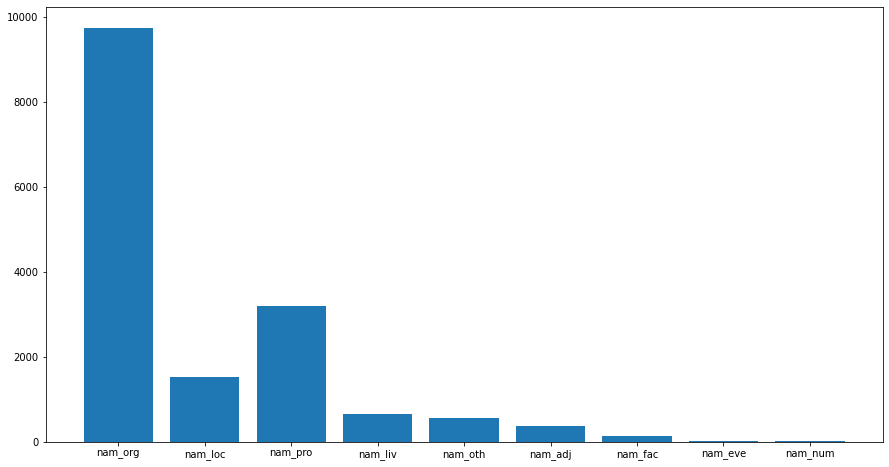

In [322]:
plt.figure(figsize=(15, 8))
plt.bar(coarse_grained_class_counter.keys(), coarse_grained_class_counter.values())

## Display 10 most frequent Named Entities for each coarse-grained type.

In [323]:
coarse_grained_class_entity_counter = collections.defaultdict(lambda: collections.defaultdict(int))

for file in tqdm.tqdm([file for file in os.listdir(RESULT_DIRECTORY) if file.endswith('.ccl')]):
    annotations = ccl_ner(os.path.join(RESULT_DIRECTORY, file))
    for annotation in annotations:
        category = annotation.get_category()
        entity = annotation.get_lemma()
        coarse_category = '_'.join(category.split('_')[:2])
        coarse_grained_class_entity_counter[coarse_category][entity] += 1

100%|██████████| 50/50 [00:50<00:00,  1.01s/it]


In [324]:
for category, entities in coarse_grained_class_entity_counter.items():
    print('-----------------------------------------------------------')
    for entity, count in list(sorted(entities.items(), key=lambda pair: -pair[1]))[:10]:
        print(f'| {category} | {str(count).ljust(4)} | {entity.ljust(38)} |')
print('-----------------------------------------------------------')

-----------------------------------------------------------
| nam_org | 295  | Skarbu Państwa                         |
| nam_org | 291  | Unii Europejskiej                      |
| nam_org | 261  | Rada Ministrów                         |
| nam_org | 239  | Państwowej Straży Pożarnej             |
| nam_org | 233  | Minister Sprawiedliwości               |
| nam_org | 213  | Prezes Rady Ministrów                  |
| nam_org | 162  | Minister Obrony Narodowej              |
| nam_org | 152  | Minister Finansów                      |
| nam_org | 137  | Urzędu Ochrony Państwa                 |
| nam_org | 114  | EFTA                                   |
-----------------------------------------------------------
| nam_loc | 812  | Rzeczypospolitej Polskiej              |
| nam_loc | 52   | Rzeczpospolita Polska                  |
| nam_loc | 51   | Polsce                                 |
| nam_loc | 39   | Rzeczpospolitą Polską                  |
| nam_loc | 32   | Warszawie            

## Display 50 most frequent Named Entities including their count and fine-grained type.

In [325]:
fine_grained_class_entity_counter = collections.defaultdict(int)

for file in tqdm.tqdm([file for file in os.listdir(RESULT_DIRECTORY) if file.endswith('.ccl')]):
    annotations = ccl_ner(os.path.join(RESULT_DIRECTORY, file))
    for annotation in annotations:
        category = annotation.get_category()
        entity = annotation.get_lemma()
        fine_grained_class_entity_counter[(entity, category)] += 1

100%|██████████| 50/50 [00:51<00:00,  1.03s/it]


In [326]:
sorted_fine_grained_class_entity_counter = sorted(
    fine_grained_class_entity_counter.items(),
    key=lambda pair: -pair[1]
)

print('-----------------------------------------------------------------------------------')
for entity, count in sorted_fine_grained_class_entity_counter[:50]:
    entity, category = entity
    print(f'| {str(count).ljust(4)} | {entity.ljust(48)}| {category.ljust(22)} |')
print('-----------------------------------------------------------------------------------')

-----------------------------------------------------------------------------------
| 1534 | Dz . U .                                        | nam_pro_media_periodic |
| 812  | Rzeczypospolitej Polskiej                       | nam_loc_gpe_country    |
| 295  | Skarbu Państwa                                  | nam_org_institution    |
| 293  | zł                                              | nam_oth_currency       |
| 290  | Unii Europejskiej                               | nam_org_organization   |
| 261  | Rada Ministrów                                  | nam_org_institution    |
| 233  | Minister Sprawiedliwości                        | nam_org_institution    |
| 213  | Prezes Rady Ministrów                           | nam_org_institution    |
| 205  | Państwowej Straży Pożarnej                      | nam_org_organization   |
| 162  | Minister Obrony Narodowej                       | nam_org_institution    |
| 152  | Minister Finansów                               | nam_org_instituti

## Answer the following questions:
### Which of the method (counting expressions with capital letters vs. NER) worked better for the task concerned with identification of the proper names?

Jak chodzi o *nazwy własne*, to żadna z metod tak naprawdę nie sprawdza się idealnie.

Za [PWN](https://sjp.pwn.pl/poradnia/haslo/Co-jest-nazwa-wlasna;1083.html):

> Nazwa własna to indywidualna nazwa osoby, rzeczy, instytucji, organizacji lub miejsca, pisana wielką literą. Świadectwem jej indywidualnego charakteru jest to, że nazw własnych zazwyczaj nie używa się w liczbie mnogiej. Wielką literą piszemy jednak też inne wyrazy, które nazwami własnymi nie są, np. nazwy mieszkańców krajów, krain i kontynentów (ale nie miast). Z drugiej strony zaś pewne nazwy indywidualne i nie używane w liczbie mnogiej nie są uważane za własne, np. nazwy walut. Spośród wymienionych przez Pana przykładów nazwą własną jest tylko Cobol. Jest on także skrótowcem (od angielskiego Common Business Oriented Language) – jedno drugiemu nie przeczy. 

Metoda oparta o słowa pisane wielką literą uwzględnia wspomnianych wyżej mieszkańców krajów, krain i kontynentów oraz wszelkie inne wyrażenia pisane wielką literą. Nie uwzględnia za to chociażby słowa `cobol` pisanego małą literą - nie wiem, czy jest to poprawny zapis, skoro wielka litera jest warunkiem koniecznym dla nazwy własnej, jednakże taką właśnie pisownię zastosowała osoba zadająca pytanie na stronie PWN.

NER uwzlędnia za to m.in. nazwy walut (`euro`, `zł`), które nie są uznawane za nazwy własne. Choć przeznaczona jest na nie osobna kategoria (`nam_oth`), to jest ona poświęcona również nazwom technologii, więc `cobol` potencjalnie wpadłby w ten sam kubełek. W powyższych wynikach można zauważyć, że również `Minister Edukacji Narodowej` został uznany za właśnie `nam_oth`. NER wykrywa również wyrażenia liczbowe (`nam_num`) czy przymiotniki pochodzące od nazw własnych (`num_adj`), które również nie stanowią nazw własnych.

Jeśli chodzi o szeroko pojęte *jednostki identyfikacyjne*, a nie tylko *nazwy własne*, to analiza działania tych dwóch metod znajduje się w poniższych punktach.

### What are the drawbacks of the method based on capital letters?
Oryginalnie wśród wyników pojawiło się sporo metadanych z jednego z plików, jednak po usunięciu tego fragmentu z odpowiedniej ustawy, problem zniknął. Później wśród wyników zauważyłam liczne rzymskie cyfry, co skłoniło mnie do dalszych modyfikacji swojej metody. Ostatecznie wśród wyników można zauważyć wiele sensownych jednostek takich jak `rzeczpospolita polski` czy `unia europejski`, jednak występuje też wiele pospolitych słów takich jak `tkanina` czy `pozostały`. Być może są one częścią jakichś nazw właśnych, z których istnienia nie zdaję sobie sprawy, jednak zauważyłam, że część problemów wynika z występowania w tekście różnego rodzaju tabel.

Przykład z `2000_700.txt`:

```
                                              Załącznik Nr 1 do ustawy
                                                z dnia ...........
            WYKAZ ROCZNYCH STAWEK AMORTYZACYJNYCH
            Symbol                                     
Poz Staw     KŚT         Nazwa środków trwałych     Powiąz
y-   ka     (grupa                                  anie z
cja   %      lub                                     KRŚTpodgrupa
91
             lub
           rodzaj)
           
[...]
           
              70     Kolejowy tabor szynowy           70
                     naziemny
              71     Kolejowy tabor szynowy           71
                     podziemny
              72     Tramwajowy tabor szynowy         72
              73     Pozostały tabor szynowy          73
                     naziemny
```

Komórki takich tabel nie są rozpoznawane przez `nltk` jako osobne zdania (co przedstawione jest we fragmencie kodu poniżej), więc występujące w nich słowa pisane wielką literą zostały zliczone jako jednostki identyfikacyjne.

In [327]:
table = '\
              70     Kolejowy tabor szynowy           70\n\
                     naziemny\n\
              71     Kolejowy tabor szynowy           71\n\
                     podziemny\n\
              72     Tramwajowy tabor szynowy         72\n\
              73     Pozostały tabor szynowy          73\n\
                     naziemny'

nltk.tokenize.sent_tokenize(table, language='polish')

['              70     Kolejowy tabor szynowy           70\n                     naziemny\n              71     Kolejowy tabor szynowy           71\n                     podziemny\n              72     Tramwajowy tabor szynowy         72\n              73     Pozostały tabor szynowy          73\n                     naziemny']

Oprócz najbardziej popularnych rezultatów spojrzałam również na najdłuższe nazwy jednostek identyfikacyjnych. Wśród tych wyników znalazło się wiele fragmentów tekstu pisanych w całości wielkimi literami. Choć zastanawiałam się nad tym, jak można by to obejść, to niestety nie przyszło mi do głowy nic mądrego.

In [328]:
results = count_capitalized_expressions(lemmatized_acts.values(), raw=True)
sorted(results.items(), key=lambda pair: -len(pair[0]))[:10]

[('ROZMIARÓW DZIAŁÓW SPECJALNYCH PRODUKCJI ROLNEJ ORAZ NORM SZACUNKOWYCH DOCHODU ROCZNEGO Jednostka Norma Lp Rodzaje',
  1),
 ('Senatu Rzeczypospolitej Polskiej WYKAZ OKRĘGÓW WYBORCZYCH DO SEJMU RZECZYPOSPOLITEJ POLSKIEJ OKRĘG WYBORCZY NR',
  1),
 ('Senatu Rzeczypospolitej Polskiej WYKAZ OKRĘGÓW WYBORCZYCH DO SENATU RZECZYPOSPOLITEJ POLSKIEJ Województwo',
  1),
 ('Rządowe Centrum Informatyczne Powszechnego Elektronicznego Systemu Ewidencji Ludności',
  1),
 ('Zarządem Głównym Związku Ochotniczych Straży Pożarnych Rzeczypospolitej Polskiej',
  1),
 ('WYTWÓRCZO-USŁUGOWEJ OBJĘTEJ OPODATKOWANIEM W FORMIE KARTY PODATKOWEJ Objaśnienie',
  1),
 ('Przewodniczący Komisji Krajowej Niezależnego Samorządnego Związku Zawodowego',
  1),
 ('WYKAZ WYROBÓW AKCYZOWYCH OBJĘTYCH OBOWIĄZKIEM OZNACZANIA ZNAKAMI AKCYZY Poz',
  1),
 ('WYKAZ ROCZNYCH STAWEK AMORTYZACYJNYCH Symbol KŚT Powiązanie Pozycja Stawka',
  1),
 ('Prezesa Zarządu Państwowego Funduszu Rehabilitacji Osób Niepełnosprawnych',
  1)]

Kolejnym problemem związanym z tą metodą jest pomijanie nazw zawierających spójniki lub interpunkcję (jak `Ministerstwo Rodziny i Polityki Społecznej` czy `Ministerstwo Rozwoju, Pracy i Technologii`). Choć pominięcie spójników i interpunkcji nie byłoby trudne w realizacji, to prowadziłoby do sytuacji, kiedy to fragmenty takie jak `Minister Rolnictwa, Minister Edukacji oraz Minister Rozwoju, Pracy i Technologii wchodzą do baru...` stawałyby się nagle jedną jednostką identyfikacyjną. Rozróżnienie tych przypadków wydaje się dosyć trudne i raczej nie byłoby możliwe bez głębszej analizy tekstu.

Mogę sobie również wyobrazić, że występują pewnie sytuacje, kiedy to jednostki identyfikacyjne pojawiają się w tekście bez rozdzielenia interpunkcją czy spójnikami. Mam tutaj na myśli zdania typu `Minister Pracy Senat odwiedził` - choć szyk jest oczywiście nieco niezręczny, to ilustruje fakt, że bez rozróżnienia części zdania i zależności między nimi nasz algorytm nie jest do końca niezawodny w takich sytuacjach.

Kolejny problem wynikałby z występowania nazw własnych na początku zdań (`Minister Rolnictwa powiedział, że...`) - choć starałam się mu zaradzić poprzez analizę formy podstawowej słowa oraz formy odmienionej, to jest możliwe, że i tak wystąpiły sytuacje, gdzie okazało się to problemem (choć niewątpliwie pomogło w przypadku chociażby imion czy nazw państw).

Metoda ta nie pozwala również na znalezienie jednostek identyfikacyjnych takich jak nazwy walut czy przymiotniki pochodzące od nazw własnych (podczas gdy NER znajduje również takie wyrażenia).

### What are the drawbacks of the method based on NER?
Wyniki metody NER pod pewnymi względami prezentują się znacznie lepiej, jednak można wśród nich zauważyć sporo duplikatów (jak `Państwowa Komisja Wyborcza` i `Państwowej Komisji Wyborczej` czy `Rzeczypospolitej Polskiej` i `Rzeczpospolita Polska`). W przypadku naiwnej metody wykonana została tokenizacja i lematyzacja, która pozwoliła na uzgodnienie formy słów na starcie.

Podobnie jak w przypadku naiwnej metody zerknęłam również na najdłuższe wyniki. Choć sytuacja wygląda nieco lepiej niż w przypadku pierwszej metody, to i tak można zauważyć kilka problematycznych wyników:
* `CHARAKTERYSTYKA DZIAŁALNOŚCI USŁUGOWEJ I WYTWÓRCZO - USŁUGOWEJ OBJĘTEJ OPODATKOWANIEM W FORMIE KARTY PODATKOWEJ Objaśnienie`,
* `+ - - - - - - - - - - - - - - - - - - - + - - - - - - - - - - - - - - - - - - - + - - - - - - - - - - - - - - - - - - - - - - - - - +`,
* `Główny Inspektor Ochrony Środowiska przekazuje Prezesowi Głównego Urzędu Ceł , Komendantowi Głównemu Straży Granicznej `.

In [339]:
sorted_by_length_fine_grained_class_entity_counter = sorted(
    fine_grained_class_entity_counter.items(),
    key=lambda pair: -len(pair[0][0])
)

for entity, count in sorted_by_length_fine_grained_class_entity_counter[:20]:
    entity, category = entity
    print(f'| {str(count)} | {entity} | {category} |')

| 2 | ustawy z dnia 11 kwietnia 1997 r . o ujawnieniu pracy lub służby w organach bezpieczeństwa państwa lub współpracy z nimi w latach 1944 - 1990 osób pełniących funkcje publiczne | nam_pro_title_document |
| 2 | ustawie z dnia 28 grudnia 1989 r . o szczególnych zasadach rozwiązywania z pracownikami stosunków pracy z przyczyn dotyczących zakładu pracy oraz o zmianie niektórych ustaw | nam_pro_title_document |
| 1 | ustawy z dnia 29 lipca 2005 r . o ofercie publicznej i warunkach wprowadzania instrumentów finansowych do zorganizowanego systemu obrotu oraz o spółkach publicznych | nam_pro_title_document |
| 1 | ustawie z dnia 25 maja 2001 r . o przebudowie i modernizacji technicznej oraz finansowaniu Sił Zbrojnych Rzeczypospolitej Polskiej w latach 2001 - 2006 | nam_pro_title_document |
| 1 | ustawy o ujawnieniu pracy lub służby w organach bezpieczeństwa państwa lub współpracy z nimi w latach 1944 - 1990 osób pełniących funkcje publiczne | nam_pro_title_document |
| 1 | rozporządzeniu 

Jak to bywa z modelami, za wadę uznałabym w pewnym sensie również fakt, że jest to czarna skrzynka, która wypluwa *jakieś* wyniki uznawane za statystycznie dobre i nie mamy za bardzo informacji odnośnie tego, dlaczego wyniki są takie, a nie inne.

Jak chodzi o wygodę działania, to obydwie metody potrzebowały trochę czasu, żeby skończyć działanie - w przypadku metody naiwnej czasochłonna była tokenizacja i lematyzacja, a w przypadku NER ewaluacja modelu, jednak nie był to jakiś dramatycznie długi czas. W przypadku NER bardziej problematyczna okazała się niezbędna ilość pamięci - jakoś koło 40 dokumentu padał mi kontener, więc ostatecznie byłam zmuszona zamknąć wszystkie okna i karty poza Jupyterem oraz terminalem.

### Which of the coarse-grained NER groups has the best and which has the worst results? Try to justify this observation.

Zgodnie z [podlinkowaną prezentacją](http://clarin-pl.eu/pliki/warsztaty/Wyklad3-inforex-liner2.pdf#page=4&zoom=auto,-256,540):

> Wśród jednostek identyfikacyjnych wyróżniamy dziewięć głównych grup:

> * `nam_adj` – przymiotniki pochodzące od nazw własnych,
> * `nam_eve` – wydarzenia organizowane lub ustalone przez ludzi oraz klęski żywiołowe,
> * `nam_fac` – konstrukcje (budowle, budynki, pomniki) stworzone przez ludzi,
> * `nam_liv` – istoty żywe (ludzie, postacie, zwierzęta),
> * `nam_loc` – toponimy (lokalizacje, jednostki geopolityczne i geograficzne),
> * `nam_num` – wyrażenia liczbowe,
> * `nam_org` – organizacje, instytucje, zespoły, zorganizowane grupy itd.
> * `nam_oth` – nazwy technologii, walut, adres e-mail, strony www, itd.
> * `nam_pro` – chrematonimy (wytwory ludzkie).


Analiza uzyskanych wyników:

* `nam_org` - wyniki są sensowne. Nie mam jedynie pewności co do rezultatów takich jak `Prezes Rady Ministrów` czy `Minister Finansów` - nie wiem, czy tego typu stanowiska powiązane z organizacjami zaliczają się do "organizacji, instytucji, zespołów, zorganizowanych grup itd.",
* `nam_loc` - wśród wyników znajduje się wiele duplikatów w różnych formach (3x `Rzeczpospolita Polska`, 2x `Polska`, 3x `Warszawa`). W tej kategorii znalazł się również `Nawóz`, który raczej nie za bardzo tutaj pasuje (zakładałabym, że znalazł się tutaj z powodu jakiejś tabelki),
* `nam_pro` - po szybkim riserczu odnoszę wrażenie, że definicja chrematonimów jest kwestią dosyć skomplikowaną, jednak wyniki takie jak `Spraw Wewnętrznych` czy `Kodeksu postępowania cywilnego` nie wydają się mieć wiele wspólnego z "wyrobem rąk ludzkich",
* `nam_liv`- wśród wyników znalazły się wyrażenia takie jak `Straż Graniczna` czy `Siły Zbrojne` - nie są to konkretne istoty żywe, ale faktycznie są to wyrażenia opisujące w jakiś sposób ludzi. Wyniku uwzględniają również dwie formy słowa `Pan`. Mniej sensowne są wyniki takie jak `Art` (chyba że zostało uznane za imię?), `Gospodarka Żywnościowa` czy `Krajowy Depozyt`,
* `nam_oth` - w tej kategorii widzę głównie nazwy walut i skrótowce. O ile te pierwsze faktycznie powinny się tutaj znajdnować, to nigdzie nie znalazłam informacji, żeby skrótowce takie jak `PESEL` czy `NIP` były przypisane do tej kategorii. Najwięcej wątpliwości budzi `Minister Edukacji Narodowej`. Nie widzę też żadnych wyników związanych z nazwami technologii czy stronami WWW.
* `nam_adj` - wśród wyników faktycznie znajdują się przymiotniki od nazw własnych takich jak `Polska` czy `Europa`. Niepoprawny wydaje się wynik `Wojewódzki`.
* `nam_fac` - żaden z wyników nie wydaje się pasować do definicji "konstrukcje (budowle, budynki, pomniki) stworzone przez ludzi". Część wyrażeń opisuje ludzi (`Inspektor Nadzoru Wewnętrznego`, `Komendant Główny`), część pierwiastki chemiczne (`Molibden`, `Mn`), a część lokalizacje geograficzne (`Zatoka Gdańska`). Jedynie `Krajowy Rejestr Karny` i `Straż Graniczną` być może można by uznać za odpowiadające definicji, gdybyśmy uznali te określenia za odniesienia do siedzib tych organizacji,
* `nam_eve` - poprawnym wynikiem najprawdopoodobniej jest `EURO` (w odniesieniu do EURO 2012). Nie widzę związku z nazwą kateorii w przypadku wyników takich jak `Maksymalne Limity Pozostałości`, `Monitor Sądowy` czy `Narodowy Bank Polski`, jednak największą zagadką pozostaje fraza `wojny polegli` - faktycznie odnosi się ono do jakiegoś wydarzenia czy klęski, jednak nie jest jednostką identyfikacyjną,
* `nam_num` - jedyne dwa wyniki to `1` i `112`, co faktycznie ma sens.

Podsumowując, za najlepsze uznałabym wyniki `nam_org`, `nam_loc`, `nam_adj`, `nam_num`, a za najsłabsze `nam_pro`, `nam_fac`, `nam_eve`, `nam_liv`. Nie mam pewności co do skrótowców w przypadku klasy `nam_oth`.

### Do you think NER is sufficient for identifying different occurrences of the same entity (i.e. consider "USA" and "Stany Zjednoczone" and "Stany Zjednoczone Ameryki Północnej") ? If not, can you suggest an algorithm or a tool that would be able to group such names together?
NER nie radzi sobie nawet z odmianą przez przypadki, więc ciężko tutaj mówić o synonimach. Najbardziej pomocny byłaby pewnie Słowosieć.

### Can you think of a real world problem that would benefit the most from application of Named Entity Recognition algorithm?
* Targetowanie artykułów czy reklam na podstawie wyszukiwanych fraz, przeglądanych stron czy pisanych wiadomości. 
* Komunikacja z Siri czy innym asystentem (asystentką) głosową o żeńskim imieniu i komunikaty typu `Zadzwoń do Johna Smitha` czy `Jak dojechać MPK do Galerii Krakowskiej?`.
* Wykrywanie zagrożeń w przypadku haseł typu `ISIS`.